#Golden Cross / Death Cross S&P 500 index (^GSPC)

In [49]:
%matplotlib inline

Use future imports for python 3.0 forward compatibility

In [50]:
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

Other imports

In [51]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

# Double the DPI, so we are making 2x plots:
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Some global data

In [52]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 100000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Fetch symbol data from internet

In [53]:
ts = pf.fetch_timeseries(symbol)

In [54]:
ts.head()

,open,high,low,close,volume,adj_close
date,,,,,,
1993-01-29,43.97,43.97,43.75,43.94,1003200,28.31
1993-02-01,43.97,44.25,43.97,44.25,480500,28.51
1993-02-02,44.22,44.38,44.12,44.34,201300,28.57
1993-02-03,44.41,44.84,44.38,44.81,529400,28.87
1993-02-04,44.97,45.09,44.47,45.00,531500,28.99


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [55]:
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)

In [56]:
ts.head()

,open,high,low,close,volume,adj_close
date,,,,,,
1993-01-29,28.33,28.33,28.19,28.31,1003200,28.31
1993-02-01,28.33,28.51,28.33,28.51,480500,28.51
1993-02-02,28.49,28.59,28.43,28.57,201300,28.57
1993-02-03,28.61,28.89,28.59,28.87,529400,28.87
1993-02-04,28.97,29.05,28.65,28.99,531500,28.99


Add technical indicator: 50 day ma, and 200 day ma

In [57]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

In [58]:
ts.tail()

,open,high,low,close,volume,adj_close,sma50,sma200
date,,,,,,,,
2016-07-01,209.48,210.49,209.29,209.92,106055300,209.92,206.86,200.32
2016-07-05,208.95,209.08,207.71,208.41,109803700,208.41,206.87,200.38
2016-07-06,207.83,209.80,207.06,209.66,96021500,209.66,206.92,200.47
2016-07-07,209.87,210.65,208.63,209.53,85593800,209.53,206.95,200.55
2016-07-08,211.05,212.94,210.78,212.65,127622100,212.65,207.04,200.66


Plot closing price along with moving averages

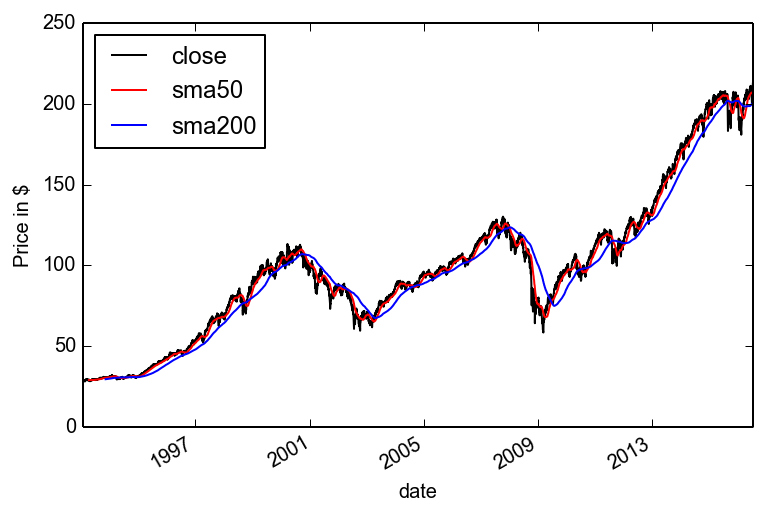

In [59]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [60]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [61]:
cash = capital
shares = 0
start_flag = True

import time
t0 = time.time()


for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

    if pd.isnull(sma200) or ts.index[i] < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = ts.index[i]
        end = ts.index[-1]

    # buy
    if tlog.num_open_trades() == 0:
        if sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1]:

            # calculate shares to buy and remaining cash
            shares, cash = tlog.calc_shares(cash, close)

            # enter buy in trade log
            tlog.enter_trade(date, close, shares)
            print("{0} BUY  {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.OPEN)
        else:
            # hold
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)

    # sell
    elif (sma50 < sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1]) or \
         (i == len(ts.index) - 1):

            # enter sell in trade log
            idx = tlog.exit_trade(date, close)
            shares = tlog.get_log()['qty'][idx]
            print("{0} SELL {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.CLOSE)   
            
            # update cash
            cash = tlog.calc_cash(cash, close, shares)
            
            # update shares
            shares = 0

    # hold
    else:
        dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)    

t1 = time.time()
total = t1-t0
print(total)
        

1994-09-01 00:00:00 BUY  3148 SPY @ 31.76
1998-10-01 00:00:00 SELL 3148.0 SPY @ 71.68
1998-12-04 00:00:00 BUY  2627 SPY @ 85.87
2000-11-02 00:00:00 SELL 2627.0 SPY @ 105.75
2002-04-19 00:00:00 BUY  3260 SPY @ 85.23
2002-05-17 00:00:00 SELL 3260.0 SPY @ 83.73
2003-05-12 00:00:00 BUY  3747 SPY @ 72.86
2004-08-25 00:00:00 SELL 3747.0 SPY @ 86.97
2004-10-27 00:00:00 BUY  3672 SPY @ 88.74
2006-07-25 00:00:00 SELL 3672.0 SPY @ 102.96
2006-08-29 00:00:00 BUY  3562 SPY @ 106.15
2007-12-28 00:00:00 SELL 3562.0 SPY @ 123.17
2009-06-18 00:00:00 BUY  5517 SPY @ 79.53
2010-07-07 00:00:00 SELL 5517.0 SPY @ 93.79
2010-10-13 00:00:00 BUY  4938 SPY @ 104.79
2011-08-17 00:00:00 SELL 4938.0 SPY @ 107.90
2012-01-23 00:00:00 BUY  4438 SPY @ 120.04
2015-09-03 00:00:00 SELL 4438.0 SPY @ 191.40
2015-12-09 00:00:00 BUY  4205 SPY @ 202.03
2016-01-15 00:00:00 SELL 4205.0 SPY @ 185.88
2016-04-20 00:00:00 BUY  3739 SPY @ 209.01
2016-07-08 00:00:00 SELL 3739.0 SPY @ 212.65
2.76337003708


Retrieve log DataFrames

In [62]:
tlog = tlog.get_log()

In [63]:
tlog.tail(100)

,entry_date,entry_price,long_short,qty,exit_date,exit_price,pl_points,pl_cash,cumul_total
0,1994-09-01,31.76,long,3148.00,1998-10-01 00:00:00,71.68,39.92,125652.44,125652.44
1,1998-12-04,85.87,long,2627.00,2000-11-02 00:00:00,105.75,19.89,52245.67,177898.10
2,2002-04-19,85.23,long,3260.00,2002-05-17 00:00:00,83.73,-1.49,-4873.49,173024.61
3,2003-05-12,72.86,long,3747.00,2004-08-25 00:00:00,86.97,14.12,52896.68,225921.29
4,2004-10-27,88.74,long,3672.00,2006-07-25 00:00:00,102.96,14.23,52245.09,278166.38
5,2006-08-29,106.15,long,3562.00,2007-12-28 00:00:00,123.17,17.02,60626.25,338792.63
6,2009-06-18,79.53,long,5517.00,2010-07-07 00:00:00,93.79,14.26,78668.97,417461.60
7,2010-10-13,104.79,long,4938.00,2011-08-17 00:00:00,107.90,3.11,15362.87,432824.47
8,2012-01-23,120.04,long,4438.00,2015-09-03 00:00:00,191.40,71.36,316703.62,749528.09
9,2015-12-09,202.03,long,4205.00,2016-01-15 00:00:00,185.88,-16.15,-67900.10,681627.99


In [64]:
dbal = dbal.get_log()

In [65]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2016-07-01,787150.32,782663.47,785019.06,3739.00,128.19,1
2016-07-05,781878.32,776755.90,779373.19,3739.00,128.19,1
2016-07-06,784570.40,774325.52,784046.94,3739.00,128.19,1
2016-07-07,787748.52,780195.78,783560.85,3739.00,128.19,1
2016-07-08,796310.86,788234.60,795226.52,3739.00,128.19,2


Generate strategy stats - display all available stats

In [66]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2016-07-08
beginning_balance                                           100000
ending_balance                                           795226.52
total_net_profit                                         695226.52
gross_profit                                             768000.11
gross_loss                                               -72773.59
profit_factor                                                10.55
return_on_initial_capital                                   695.23
annual_return_rate                                            9.58
trading_period                           22 years 7 months 27 days
pct_time_in_market                                           72.04
total_num_trades                                                11
num_winning_trades                                               9
num_losing_trades                                             

Run Benchmark

In [67]:
benchmark = pf.Benchmark(symbol, capital, start, end)
benchmark.run()

1993-11-11 00:00:00 BUY  3287 SPY @ 30.42
2016-07-08 00:00:00 SELL 3287.0 SPY @ 212.65


Retrieve benchmark logs

In [68]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [69]:
benchmark.stats = benchmark.stats()
pf.print_full(benchmark.stats)

start                                                   1993-11-11
end                                                     2016-07-08
beginning_balance                                           100000
ending_balance                                           698987.25
total_net_profit                                         598987.25
gross_profit                                             598987.25
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                   598.99
annual_return_rate                                            8.96
trading_period                           22 years 7 months 27 days
pct_time_in_market                                          100.00
total_num_trades                                                 1
num_winning_trades                                               1
num_losing_trades                                             

Plot Equity Curves: Strategy vs Benchmark

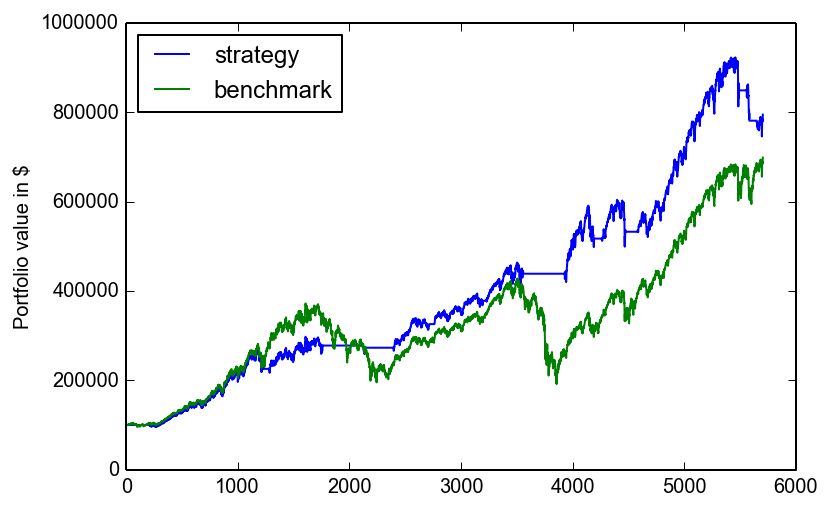

In [70]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

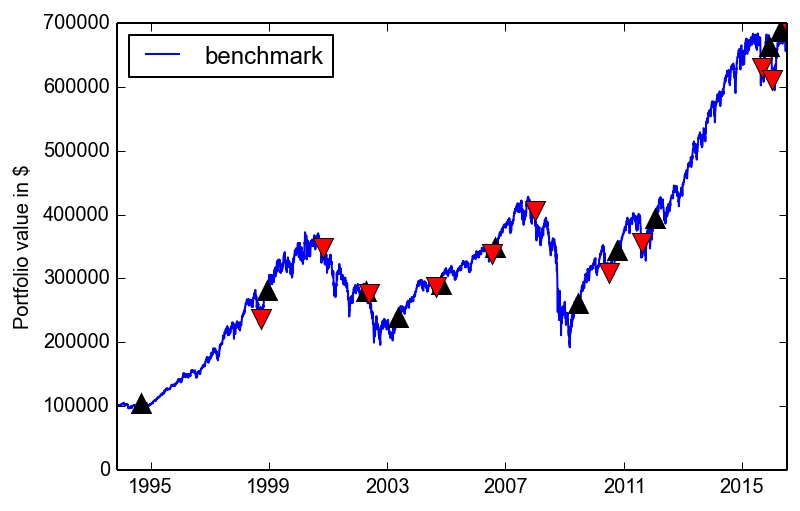

In [71]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,9.58,8.96
max_closed_out_drawdown,-19.63,-55.19
drawdown_annualized_return,-2.05,-6.16
drawdown_recovery,-0.41,-1.42
best_month,15.46,23.62
worst_month,-14.94,-29.41
sharpe_ratio,0.77,0.55
sortino_ratio,0.86,0.72
monthly_std,3.07,4.48


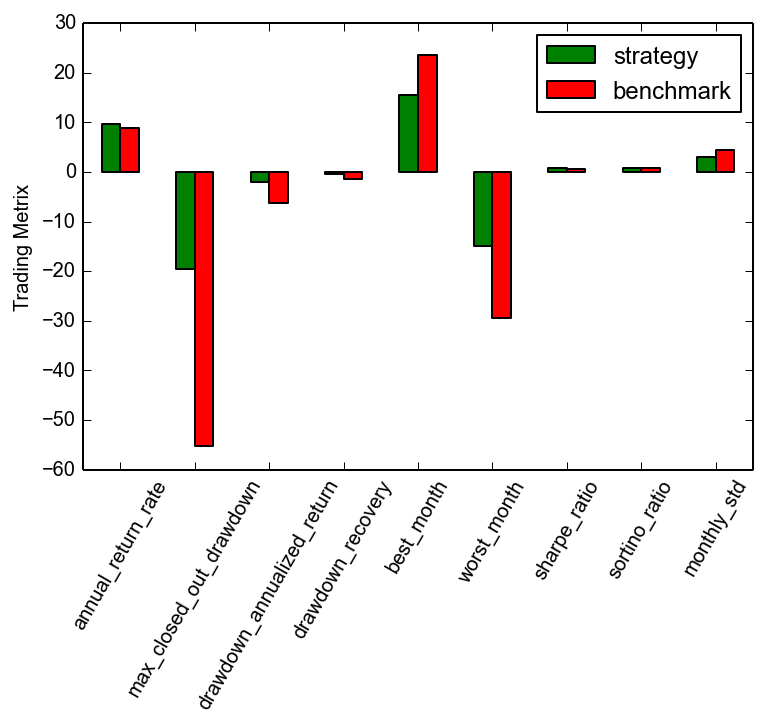

In [72]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df